In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import os

2022-10-06 18:31:38.103504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 18:31:38.252121: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-06 18:31:38.873942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/can/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2022-10-06 18:31:38.874027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not

In [2]:
BASE_PATH = '../gtsrb/'
TRAIN_PATH = BASE_PATH + 'cropped_healthy_noentry/'


data = []
labels = []

# NUM_CLASSES = len(os.listdir(TRAIN_PATH))
IMG_HEIGHT = 48
IMG_WIDTH = 48
IMG_CHAN = 3
# print("#classes: "+str(NUM_CLASSES))
img_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHAN)

# NUM_CATEGORIES = len(os.listdir(TRAIN_PATH))
#print("#categories: "+str(NUM_CATEGORIES))
#for category in range(NUM_CLASSES):
# each_class = 0
ts_noentry = os.path.join(TRAIN_PATH)
for img in os.listdir(ts_noentry):
    image = Image.open(os.path.join(ts_noentry, img))
    image = image.resize((IMG_HEIGHT,IMG_WIDTH))
    image = np.array(image)
    image = image/255.0
    data.append(image)

In [4]:
# Convert lists to NumPy arrays
data = np.array(data)

img_train, img_val = train_test_split(data,test_size=0.2, random_state=16)
print("#Train image set shape: ", img_train.shape, "#Validation image set shape: ", img_val.shape)

#Train image set shape:  (476, 48, 48, 3) #Validation image set shape:  (120, 48, 48, 3)


In [9]:
type(img_shape)

tuple

In [4]:
ae = tf.keras.models.Sequential()
ae.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=img_shape))
ae.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
ae.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
ae.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
ae.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
ae.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
ae.add(tf.keras.layers.Flatten())
ae.add(tf.keras.layers.Dense(1024, activation='relu'))
ae.add(tf.keras.layers.Dense(256, activation='relu'))
ae.add(tf.keras.layers.Dense(1024, activation='relu'))
ae.add(tf.keras.layers.Dense(5184, activation='relu'))
ae.add(tf.keras.layers.Reshape((9, 9, 64)))
ae.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
ae.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu'))
ae.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), activation='relu'))
ae.add(tf.keras.layers.UpSampling2D(size=(2, 2)))
ae.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3,3), activation='relu'))
ae.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size = (3,3), activation = 'relu'))
ae.summary()

2022-10-02 23:35:34.839341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 23:35:34.845213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/can/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2022-10-02 23:35:34.845234: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-02 23:35:34.846379: I tenso

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 16)        1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                    

In [5]:
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [6]:
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
ae.compile(loss=SSIMLoss, optimizer=optimizer, metrics=['accuracy'])
history = ae.fit(img_train, img_train, batch_size=64, epochs=100, validation_data=(img_val, img_val))

Epoch 1/100


/home/can/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 6s 530ms/step - loss: 0.9280 - accuracy: 0.1149 - val_loss: 0.8247 - val_accuracy: 0.0542
Epoch 2/100
8/8 [==============================] - 4s 462ms/step - loss: 0.7729 - accuracy: 0.0561 - val_loss: 0.6685 - val_accuracy: 0.0741
Epoch 3/100
8/8 [==============================] - 4s 464ms/step - loss: 0.6426 - accuracy: 0.1014 - val_loss: 0.6191 - val_accuracy: 0.1048
Epoch 4/100
8/8 [==============================] - 4s 466ms/step - loss: 0.6104 - accuracy: 0.0935 - val_loss: 0.5853 - val_accuracy: 0.0774
Epoch 5/100
8/8 [==============================] - 4s 463ms/step - loss: 0.5595 - accuracy: 0.0933 - val_loss: 0.5151 - val_accuracy: 0.1199
Epoch 6/100
8/8 [==============================] - 4s 471ms/step - loss: 0.4867 - accuracy: 0.3554 - val_loss: 0.4621 - val_accuracy: 0.7641
Epoch 7/100
8/8 [==============================] - 4s 470ms/step - loss: 0.4407 - accuracy: 0.7879 - val_loss: 0.4201 - val_accuracy: 0.7992
Epoch 8/100
8/8 [========

In [7]:
ae.save("autoencoder_cropped_noentry_V1.h5")

In [36]:
test_data = []
TEST_PATH = BASE_PATH + 'damaged_noentry/web_imgs/'
test_noentry = os.path.join(TEST_PATH)
for img in os.listdir(test_noentry):
    image = Image.open(os.path.join(test_noentry, img)).convert('RGB')
    image = image.resize((IMG_HEIGHT,IMG_WIDTH))
    image = np.array(image)
    image = image/255.0
    test_data.append(image)

test_data = np.array(test_data)            
gen = ae.predict(test_data)

1/1 [==============================] - 0s 29ms/step


In [37]:
tensor_val = tf.convert_to_tensor(img_val, dtype=tf.float32)
tensor_test = tf.convert_to_tensor(test_data, dtype=tf.float32)

4/4 [==============================] - 0s 49ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


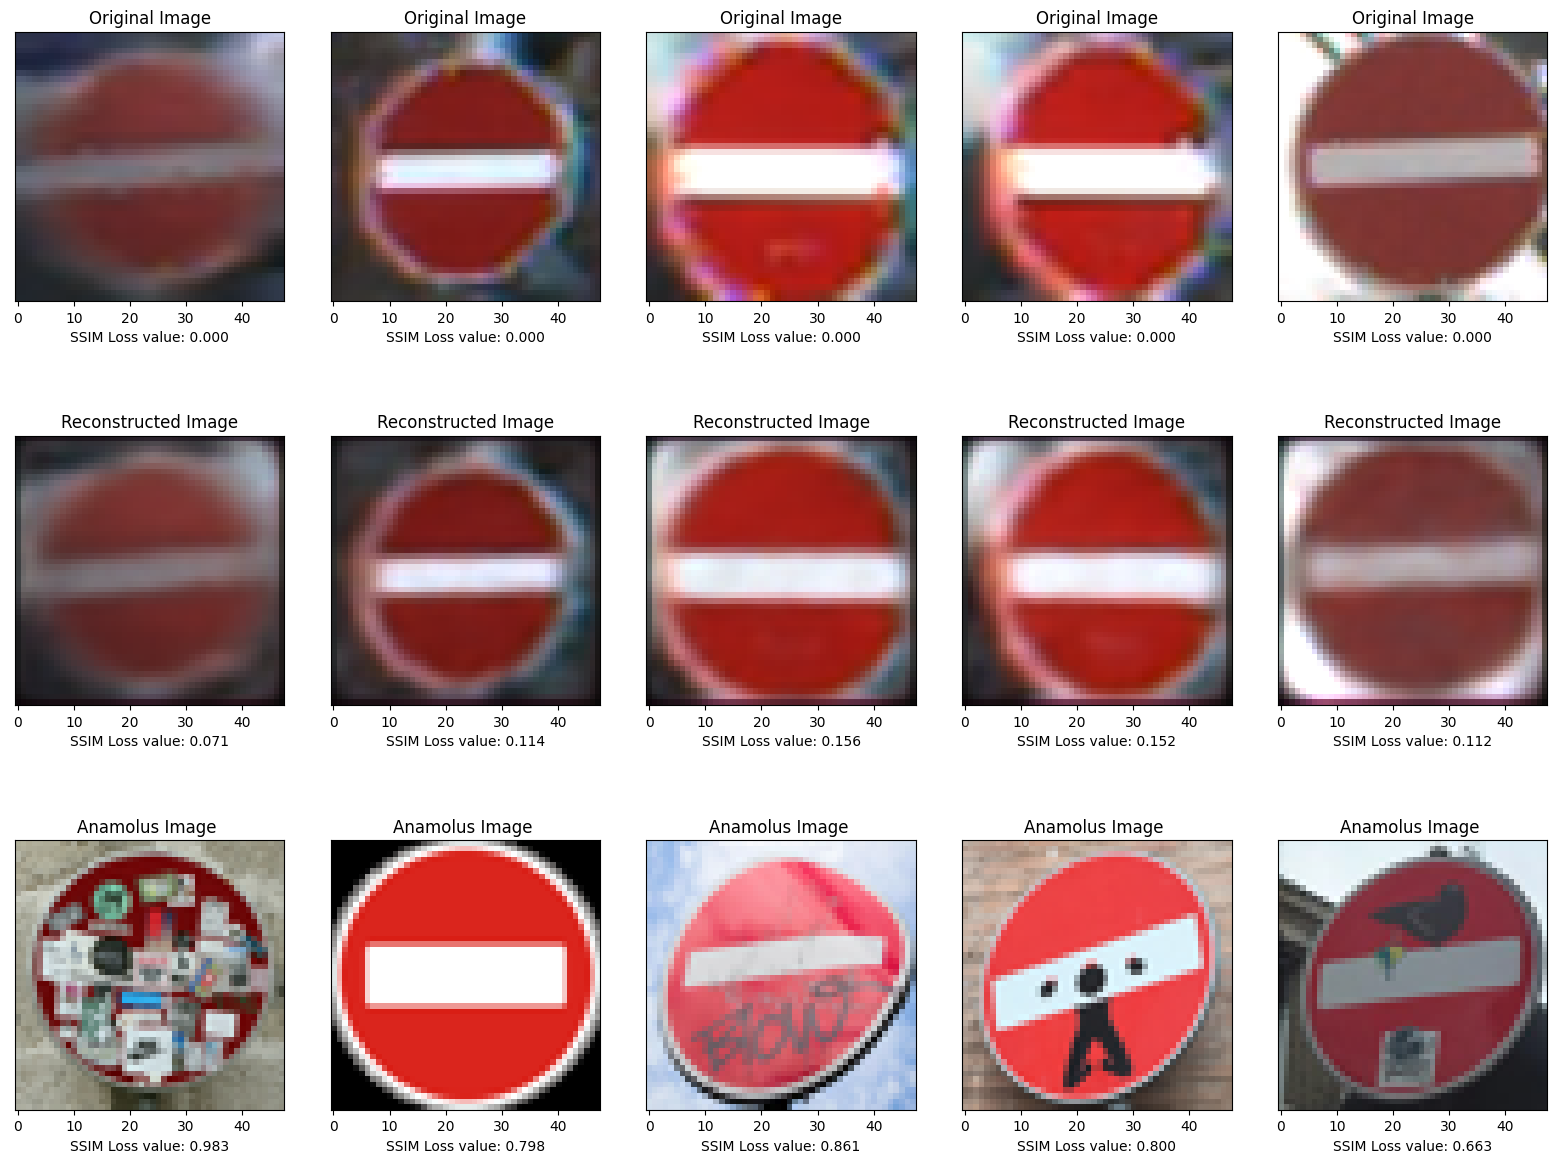

In [38]:
decoded_imgs= ae.predict(img_val)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.5)
plt_a=1
n=5
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(img_val[i].reshape(48,48,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(img_val[i], img_val[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(48,48,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(tensor_val[i], decoded_imgs[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(test_data[i].reshape(48,48,3))
    #plt.imshow(decoded_imgs[i+4].reshape(48,48,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(tensor_test[i], decoded_imgs[i])
    #value = SSIMLoss(decoded_imgs[i+4], decoded_imgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.show()

In [39]:
for i in range(len(gen)):
    avg_err = 0.0
    for j in range(len(tensor_val)):
        value_a = SSIMLoss(gen[i], decoded_imgs[j])
        avg_err += value_a/len(tensor_val)
    print(avg_err)

tf.Tensor(0.7568555, shape=(), dtype=float32)
tf.Tensor(0.57744044, shape=(), dtype=float32)
tf.Tensor(0.7934939, shape=(), dtype=float32)
tf.Tensor(0.67895275, shape=(), dtype=float32)
tf.Tensor(0.6393268, shape=(), dtype=float32)


In [40]:
for i in range(len(gen)):
    avg_err = 0.0
    for j in range(len(tensor_val)):
        value_a = SSIMLoss(tensor_test[i], decoded_imgs[j])
        avg_err += value_a/len(tensor_val)
    print(avg_err)

tf.Tensor(0.97758245, shape=(), dtype=float32)
tf.Tensor(0.66347766, shape=(), dtype=float32)
tf.Tensor(0.88554084, shape=(), dtype=float32)
tf.Tensor(0.8187488, shape=(), dtype=float32)
tf.Tensor(0.75324935, shape=(), dtype=float32)


In [35]:
for i in range(len(decoded_imgs)):
    avg_err = 0.0
    for j in range(len(tensor_val)):
        value_a = SSIMLoss(tensor_val[i], decoded_imgs[j])
        avg_err += value_a/len(tensor_val)
    print(avg_err)

tf.Tensor(0.5478437, shape=(), dtype=float32)
tf.Tensor(0.60767823, shape=(), dtype=float32)
tf.Tensor(0.57998776, shape=(), dtype=float32)
tf.Tensor(0.57422125, shape=(), dtype=float32)
tf.Tensor(0.6383793, shape=(), dtype=float32)
tf.Tensor(0.60699695, shape=(), dtype=float32)
tf.Tensor(0.8134138, shape=(), dtype=float32)
tf.Tensor(0.5573131, shape=(), dtype=float32)
tf.Tensor(0.48906314, shape=(), dtype=float32)
tf.Tensor(0.51060086, shape=(), dtype=float32)
tf.Tensor(0.5262778, shape=(), dtype=float32)
tf.Tensor(0.54242134, shape=(), dtype=float32)
tf.Tensor(0.6334824, shape=(), dtype=float32)
tf.Tensor(0.6430192, shape=(), dtype=float32)
tf.Tensor(0.5922607, shape=(), dtype=float32)
tf.Tensor(0.60048336, shape=(), dtype=float32)
tf.Tensor(0.5625569, shape=(), dtype=float32)
tf.Tensor(0.62172556, shape=(), dtype=float32)
tf.Tensor(0.5757039, shape=(), dtype=float32)
tf.Tensor(0.61078334, shape=(), dtype=float32)
tf.Tensor(0.560595, shape=(), dtype=float32)
tf.Tensor(0.6046549, shap

4/4 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


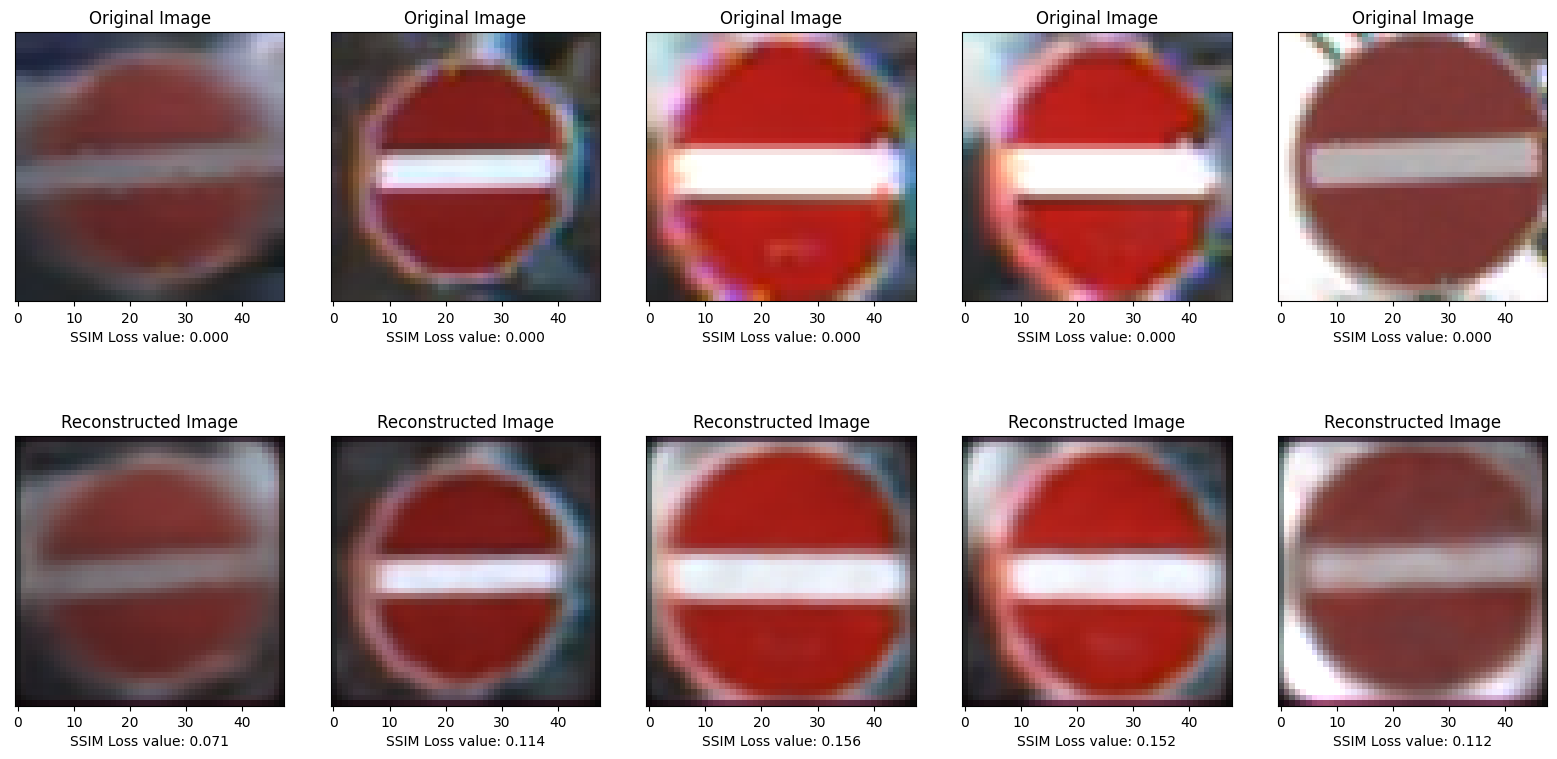

In [43]:
decoded_imgs= ae.predict(img_val)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.5)
plt_a=1
n=5
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(img_val[i].reshape(48,48,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(img_val[i], img_val[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(48,48,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(tensor_val[i], decoded_imgs[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    plt_a+=1
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


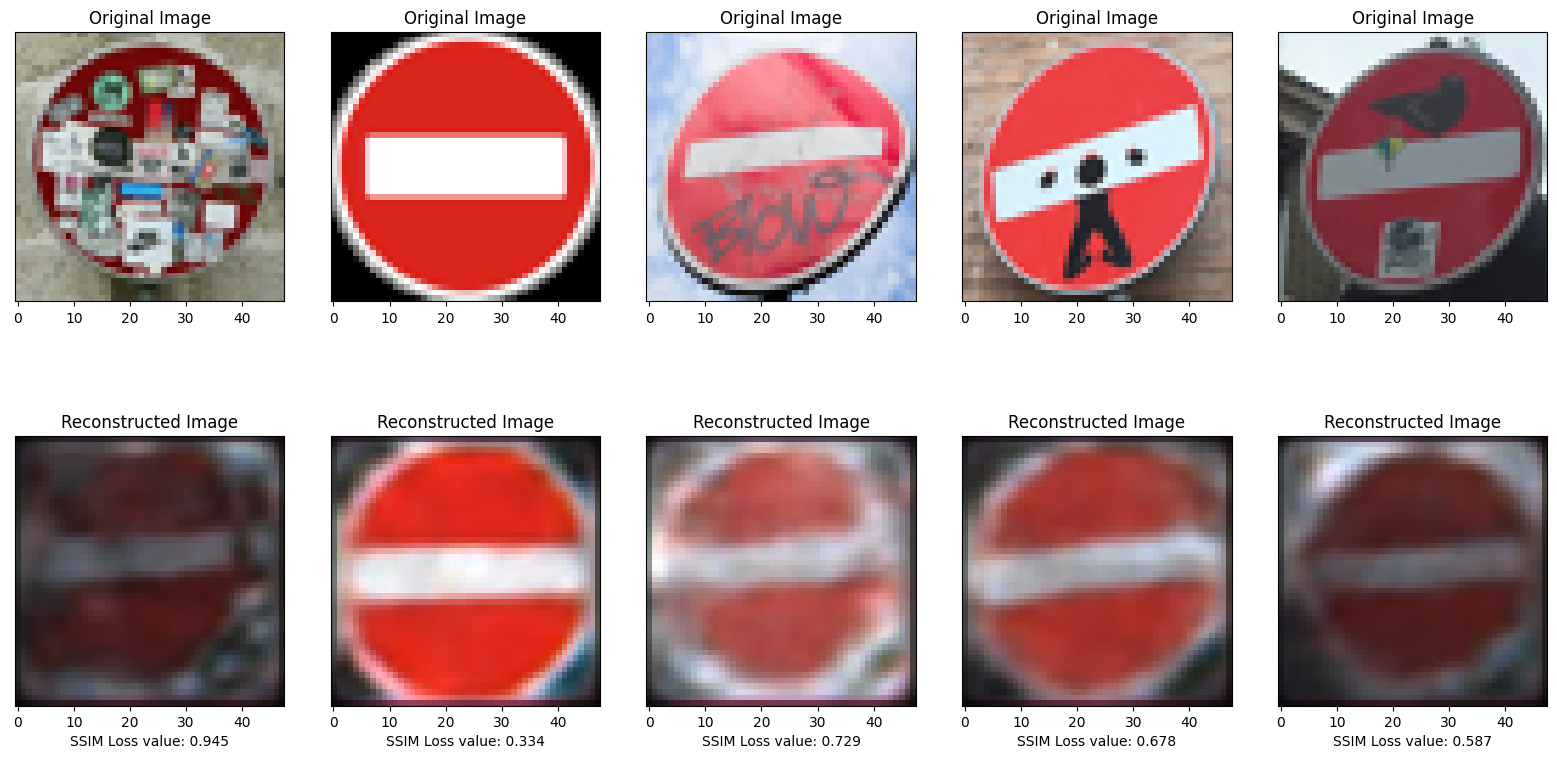

In [50]:
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.5)
plt_a=1
n=5
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(48,48,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    # value_a = SSIMLoss(img_val[i], img_val[i])
    ax.set_title("Original Image")
    # label = 'SSIM Loss value: {:.3f}'
    # ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(gen[i].reshape(48,48,3))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(tensor_test[i], gen[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    plt_a+=1
plt.show()